In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
electric_power_consumption = pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt', sep=';',
                 parse_dates={'Date_Time' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'])
electric_power_consumption.info()

<ipython-input-3-be0b6fa8d119>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  electric_power_consumption = pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt', sep=';',
<ipython-input-3-be0b6fa8d119>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  electric_power_consumption = pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt', sep=';',


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date_Time              datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [ ]:
electric_power_consumption.head()

,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
electric_power_consumption.isnull().sum()

Date_Time                    0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# Fill missing values with column means
electric_power_consumption.fillna(electric_power_consumption.mean(), inplace=True)

# Set the index to the datetime column
electric_power_consumption.set_index('Date_Time', inplace=True)

# Resample the data into hourly intervals and aggregate using mean
newdf = electric_power_consumption.resample('H').mean()

# Check for missing values after resampling
print(newdf.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [ ]:
newdf.describe()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,1.091647,0.123712,240.839755,4.627892,1.121880,1.298475,6.458390
std,0.891965,0.066402,2.981708,3.734136,3.515967,4.166688,7.304059
min,0.124000,0.000000,225.834500,0.503333,0.000000,0.000000,0.000000
25%,0.343667,0.078333,239.212333,1.520000,0.000000,0.000000,0.650000
50%,0.821767,0.107800,240.935333,3.500000,0.000000,0.333333,1.666667
75%,1.570200,0.148700,242.673667,6.563333,0.000000,0.666667,13.950000
max,6.560533,0.774333,251.902000,28.383333,48.366667,46.433333,21.550000


In [ ]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data.drop(col,axis=1,inplace = True)
    return data

In [ ]:
# Set 15 minutes as a lagging time unit, therefore lagging time will be 15 min * n, such as 15 min, 30 min, 1 hour and so on.
# The smaller this lagging time unit is, the better the predicting result is.

def get_lag(data, col, lagtime):
    for i in range(1,lagtime+1):
        if len(pd.Series(col)) == 1:
            data[col+"_lag"+str(i)] = data[col].shift(i*15)
        else:
            for col_j in col:
                data[col_j+"_lag"+str(i)] = data[col_j].shift(i*15)
    return data

In [ ]:
# Create Time Series Features

newdf['date'] = newdf.index

newdf['hour'] = newdf['date'].dt.hour
newdf = encode(newdf,'hour',24)

newdf['dayofweek'] = newdf['date'].dt.dayofweek
newdf = encode(newdf,'dayofweek',7)

newdf['month'] = newdf['date'].dt.month
newdf = encode(newdf,'month',12)

# newdf['year'] = newdf['date'].dt.year

newdf['dayofyear'] = newdf['date'].dt.dayofyear
newdf = encode(newdf,'dayofyear',365)

newdf['dayofmonth'] = newdf['date'].dt.day
newdf = encode(newdf,'dayofmonth',31)

#newdf['weekofyear'] = newdf['date'].dt.weekofyear

newdf.drop('date',axis=1,inplace = True)

In [ ]:
# adding lagging feature

# adding time lags of 15min,30min as features

lagtime = 2
lag_feature = ['Global_reactive_power','Voltage', 'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
newdf = get_lag(newdf, lag_feature, lagtime)

# adding time lags of 2 hours as features

newdf = get_lag(newdf, 'Global_active_power', 8)

newdf.drop(lag_feature,axis=1,inplace = True)

newdf.dropna(inplace=True)


In [ ]:
newdf

,Global_active_power,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,dayofmonth_sin,...,Sub_metering_2_lag2,Sub_metering_3_lag2,Global_active_power_lag1,Global_active_power_lag2,Global_active_power_lag3,Global_active_power_lag4,Global_active_power_lag5,Global_active_power_lag6,Global_active_power_lag7,Global_active_power_lag8
Date_Time,,,,,,,,,,,,,,,,,,,,,
2006-12-21 17:00:00,1.752633,-0.965926,-2.588190e-01,0.433884,-0.900969,-2.449294e-16,1.000000,-0.171293,0.985220,-0.897805,...,25.166667,17.700000,1.274900,2.892400,2.940533,0.306667,1.733033,0.437733,1.890567,4.222889
2006-12-21 18:00:00,2.443300,-1.000000,-1.836970e-16,0.433884,-0.900969,-2.449294e-16,1.000000,-0.171293,0.985220,-0.897805,...,0.083333,18.016667,0.302600,1.421033,1.442867,0.796333,1.784300,0.276367,2.549067,3.632200
2006-12-21 19:00:00,2.197133,-0.965926,2.588190e-01,0.433884,-0.900969,-2.449294e-16,1.000000,-0.171293,0.985220,-0.897805,...,0.466667,18.000000,0.246733,1.428400,0.720000,1.785633,1.949300,0.313300,3.628900,3.400233
2006-12-21 20:00:00,2.437367,-0.866025,5.000000e-01,0.433884,-0.900969,-2.449294e-16,1.000000,-0.171293,0.985220,-0.897805,...,0.050000,16.583333,0.290700,1.294900,0.383700,3.879033,2.154900,0.284467,2.471000,3.268567
2006-12-21 21:00:00,0.982267,-0.707107,7.071068e-01,0.433884,-0.900969,-2.449294e-16,1.000000,-0.171293,0.985220,-0.897805,...,0.200000,0.000000,0.295667,0.281133,0.459833,1.617767,2.402533,0.309933,1.915867,3.056467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,-0.965926,-2.588190e-01,-0.433884,-0.900969,-5.000000e-01,0.866025,-0.566702,0.823923,-0.848644,...,0.816667,10.650000,0.273433,1.028067,2.312867,0.284400,1.548633,0.322800,2.590233,0.723933
2010-11-26 18:00:00,1.573467,-1.000000,-1.836970e-16,-0.433884,-0.900969,-5.000000e-01,0.866025,-0.566702,0.823923,-0.848644,...,0.433333,0.000000,0.298367,0.499733,1.568367,0.828967,0.400000,0.365167,1.427600,0.451133
2010-11-26 19:00:00,1.659333,-0.965926,2.588190e-01,-0.433884,-0.900969,-5.000000e-01,0.866025,-0.566702,0.823923,-0.848644,...,0.000000,0.000000,0.314033,0.356233,0.422100,2.850233,0.509267,0.292433,3.105367,0.295467


In [ ]:
newdf.shape

(34469, 31)

In [ ]:
split_date =pd.to_datetime('2010-07-05')
df_train = newdf.loc[newdf.index <= split_date].copy()
df_train.shape

(30992, 31)

In [ ]:
#df_test = pd.DataFrame(newdf.loc[newdf.index > split_date]
df_test = pd.DataFrame(newdf.loc[newdf.index > split_date][:500])

df_test.shape

(500, 31)

In [ ]:
train_size = int(len(newdf) * 0.9)
train, test = newdf[:train_size], newdf[train_size:]

print(train.shape, test.shape)

(31022, 31) (3447, 31)


In [ ]:
# The target is forecasting Global_active_power.
X_train, y_train = train.iloc[:,1:],train.iloc[:,0]
X_test, y_test = test.iloc[:,1:],test.iloc[:,0]

In [ ]:
y_train

Date_Time
2006-12-21 17:00:00    1.752633
2006-12-21 18:00:00    2.443300
2006-12-21 19:00:00    2.197133
2006-12-21 20:00:00    2.437367
2006-12-21 21:00:00    0.982267
                         ...   
2010-07-06 02:00:00    0.366967
2010-07-06 03:00:00    0.357400
2010-07-06 04:00:00    0.271400
2010-07-06 05:00:00    0.313700
2010-07-06 06:00:00    0.358633
Freq: H, Name: Global_active_power, Length: 31022, dtype: float64

In [ ]:
y_test

Date_Time
2010-07-06 07:00:00    1.264100
2010-07-06 08:00:00    1.388333
2010-07-06 09:00:00    1.381867
2010-07-06 10:00:00    1.367833
2010-07-06 11:00:00    0.281600
                         ...   
2010-11-26 17:00:00    1.725900
2010-11-26 18:00:00    1.573467
2010-11-26 19:00:00    1.659333
2010-11-26 20:00:00    1.163700
2010-11-26 21:00:00    0.934667
Freq: H, Name: Global_active_power, Length: 3447, dtype: float64

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
test['Prediction'] = reg.predict(X_test)
df_all = pd.concat([test, train], sort=False)

<ipython-input-21-b929175cbab0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = reg.predict(X_test)


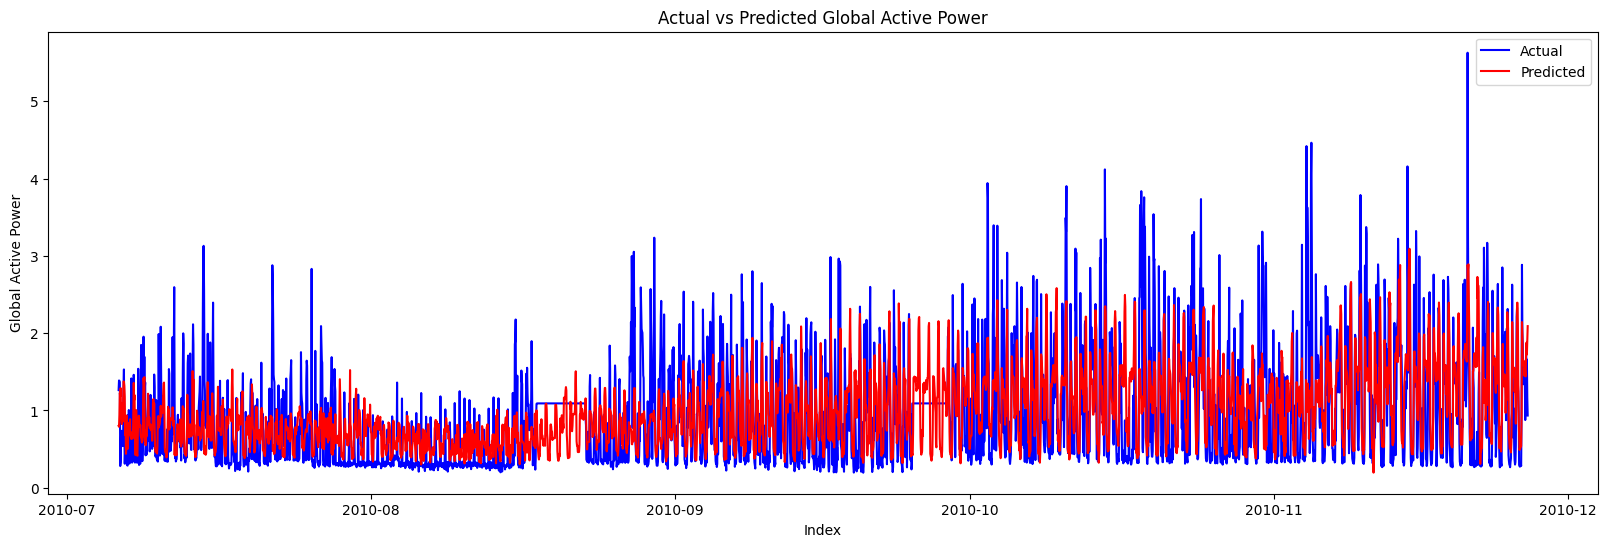

In [ ]:
# Plot actual vs predicted for the test data
plt.figure(figsize=(20, 6))
plt.plot(test.index, test['Global_active_power'], color='blue', label='Actual')
plt.plot(test.index, test['Prediction'], color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Global Active Power')
plt.title('Actual vs Predicted Global Active Power')
plt.legend()
plt.show()


RMSE and MAE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Global_active_power'], test['Prediction']))

# Calculate MAE
mae = mean_absolute_error(test['Global_active_power'], test['Prediction'])

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.5819740456286109
MAE: 0.4372154366987499
